# Trump Tariff Trauma Dashboard with Panel and HvPlot


## Visualization Library

The purpose of this notebook is to build, modify and demonstrate an interactive visualization with a custom dataset. You can play with the interactive versions towards the end of this notebook. 

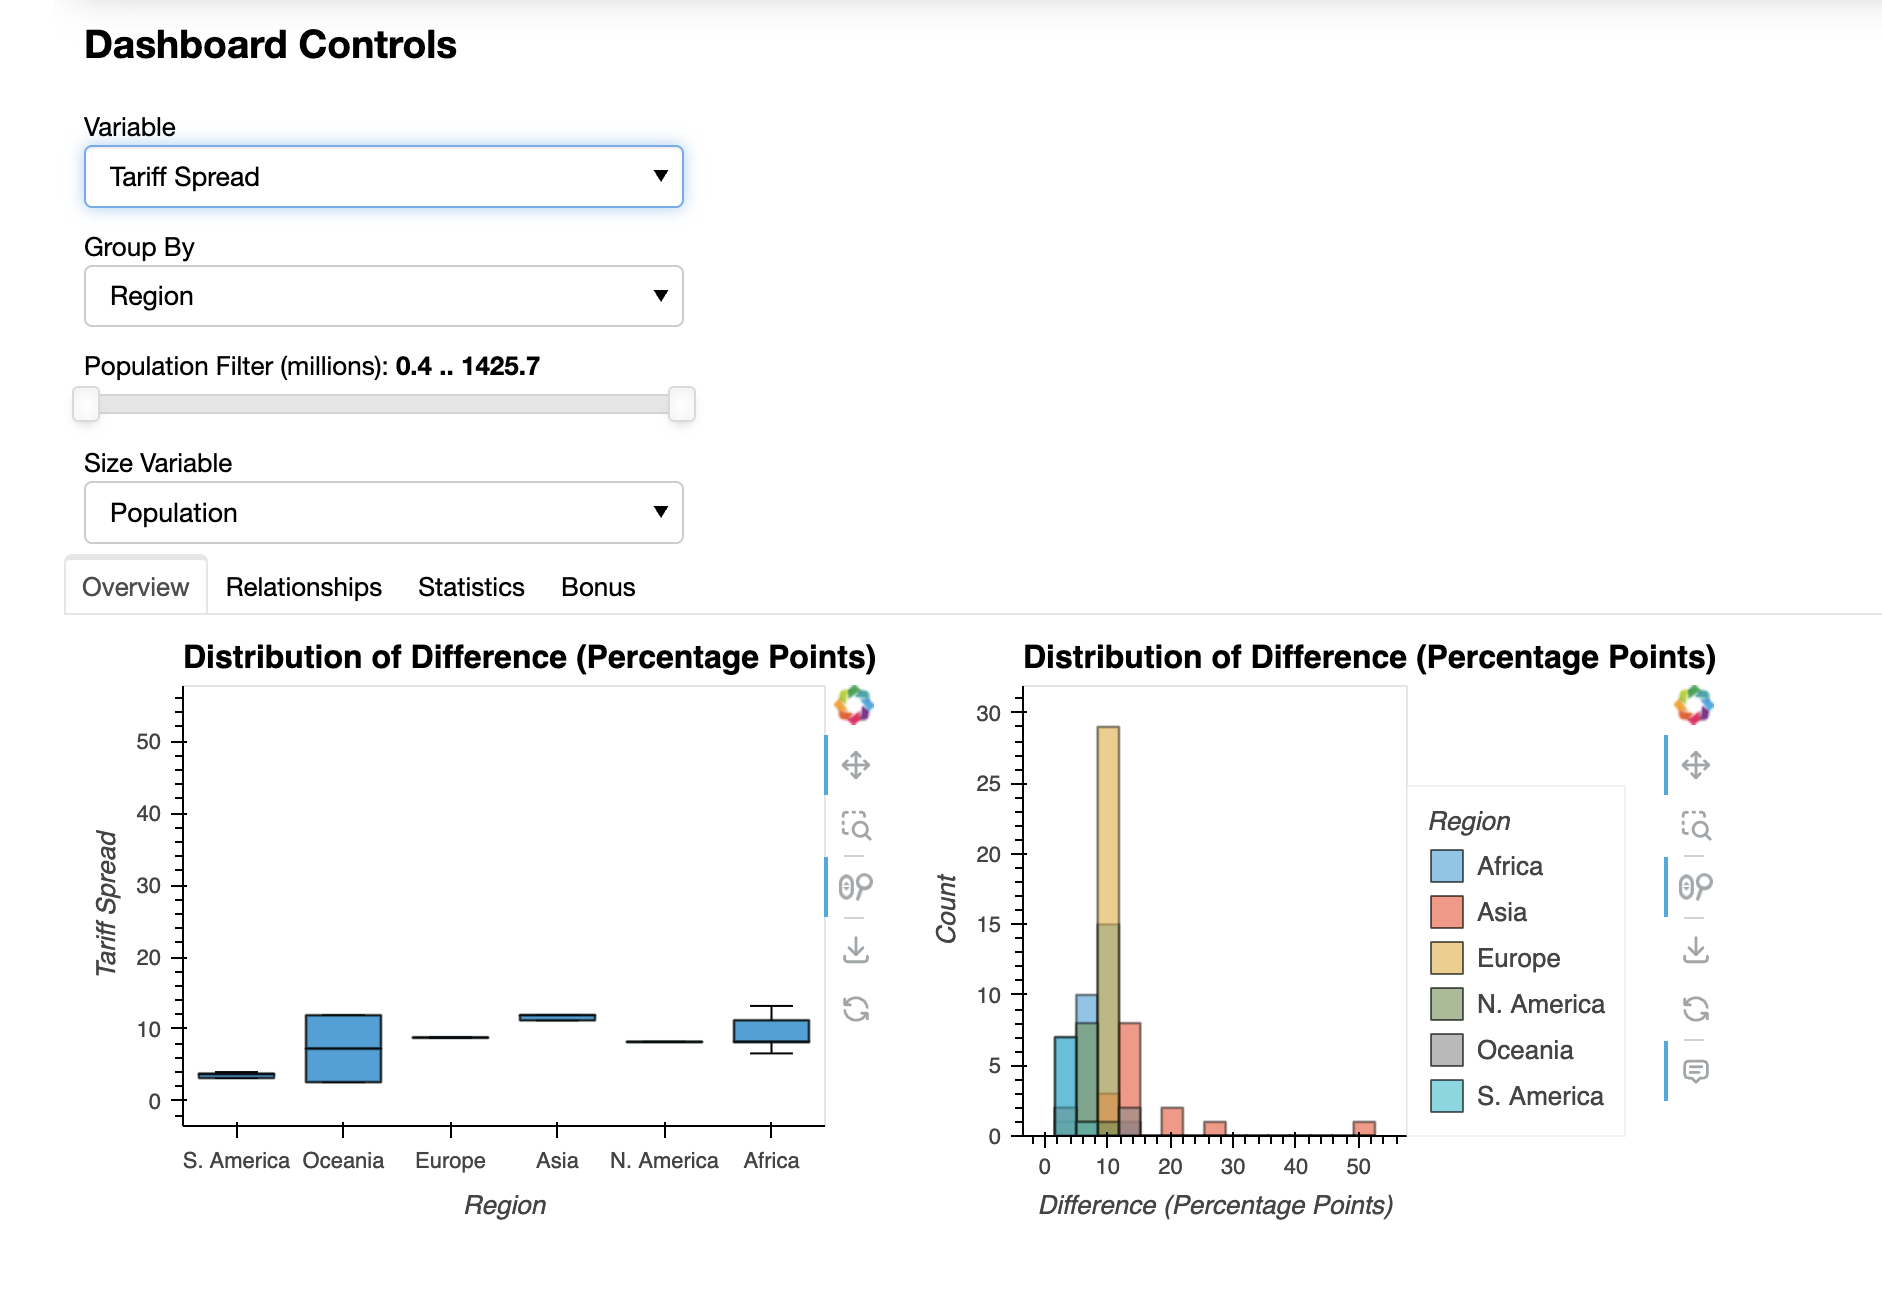

Since the instructions explicity restrict the use of Altair and Matplotlib and Bobby Madamanchi's lecture encouraged the use of the Panel and HvPlot notebooks, I chose to build on this work to emphasize the interactivity of the visualization. 


https://labs.vocareum.com/main/main.php?m=clabide&mode=s&asnid=4174033&stepid=4174034&hideNavBar=1
https://labs.vocareum.com/main/main.php?m=clabide&mode=s&asnid=4174033&stepid=4174034&hideNavBar=1

Similar to notebooks accompanying Madamanchi's demonstration using the links above, the key libraries will need to be installed ahead of time for this notebook and accompanying visualizations to work properly. 
These libraries can be installed with the the following command:

```python
!pip install panel hvplot pandas numpy seaborn jupyter_bokeh bokeh_sampledata
```

but if they have already been installed we just need to import them for use in this notebook.

The combination of the HVplot and Panel libraries will enable a hybrid approach to visualization, with many declarative aspects of defining the widgets combined with the flexibility and customization of a procedural approach. While this may sound like the best of both worlds, you can review the Key Learnings section below for additional commentary on whether it is a successful experience.


## Setting Up Your Environment

Let's import our tools and set things up. I'll explain each import and why we need it:

In [8]:
# !pip install panel hvplot pandas numpy seaborn jupyter_bokeh bokeh_sampledata
# Essential imports for our dashboard
import panel as pn                # The main dashboard framework
import hvplot.pandas             # Adds plotting methods directly to pandas DataFrames
import pandas as pd              # For data manipulation
import numpy as np               # For numerical operations
import seaborn as sns            # For additional plotting capabilities
import holoviews as hvplot       # For interactivity
from scipy import stats

# Initialize Panel extension - this is crucial!
# It enables Jupyter to display Panel objects and interactive widgets
pn.extension()

## Dataset Selection

For this visualization, we are exploring how the recent tariff rates announced by the Trump administration in the United States compare to reality of the pre-existing rates according to the WTO (World Trade Organization). This evaluation will not include the most recent changes to tariff rates, threatened rate increases or any pre-annoucements of trade deals that are not complete.

The basis for this data was the following article CNBC’s Gabriel Cortes. The article includes a table of basic data and a geographic visualization by the journalist. Additional categorical data was mapped on the country-level to look for additional patterns within our visualization. 

https://www.cnbc.com/2025/04/04/trumps-tariff-rates-for-other-countries-larger-than-word-trade-data.html

The dataset includes the following columns:
* Country/Region
* Trump Admin "White House Calculation" (%)
    * I included this column, also referredt to as Trump_Admin_Calc but did not focus on the issues of how this calculation was made by the administration
* WTO Trade-Weighted Average (%)
    * What the WTO reports as the actual tariff rate between the US and each country in the dataset
* Difference (Percentage Points)
    * Also referred to as Tariff Spread. The difference between the rate claimed by the Trump administration and the WTO rate
* Trump Admin "USA Discounted Reciprocal Tariffs" (%)
* Trade Agreement
* Population (millions)
* GDP (USD billions)
* Pop. Rank
* Primary Region
* Key Market Group

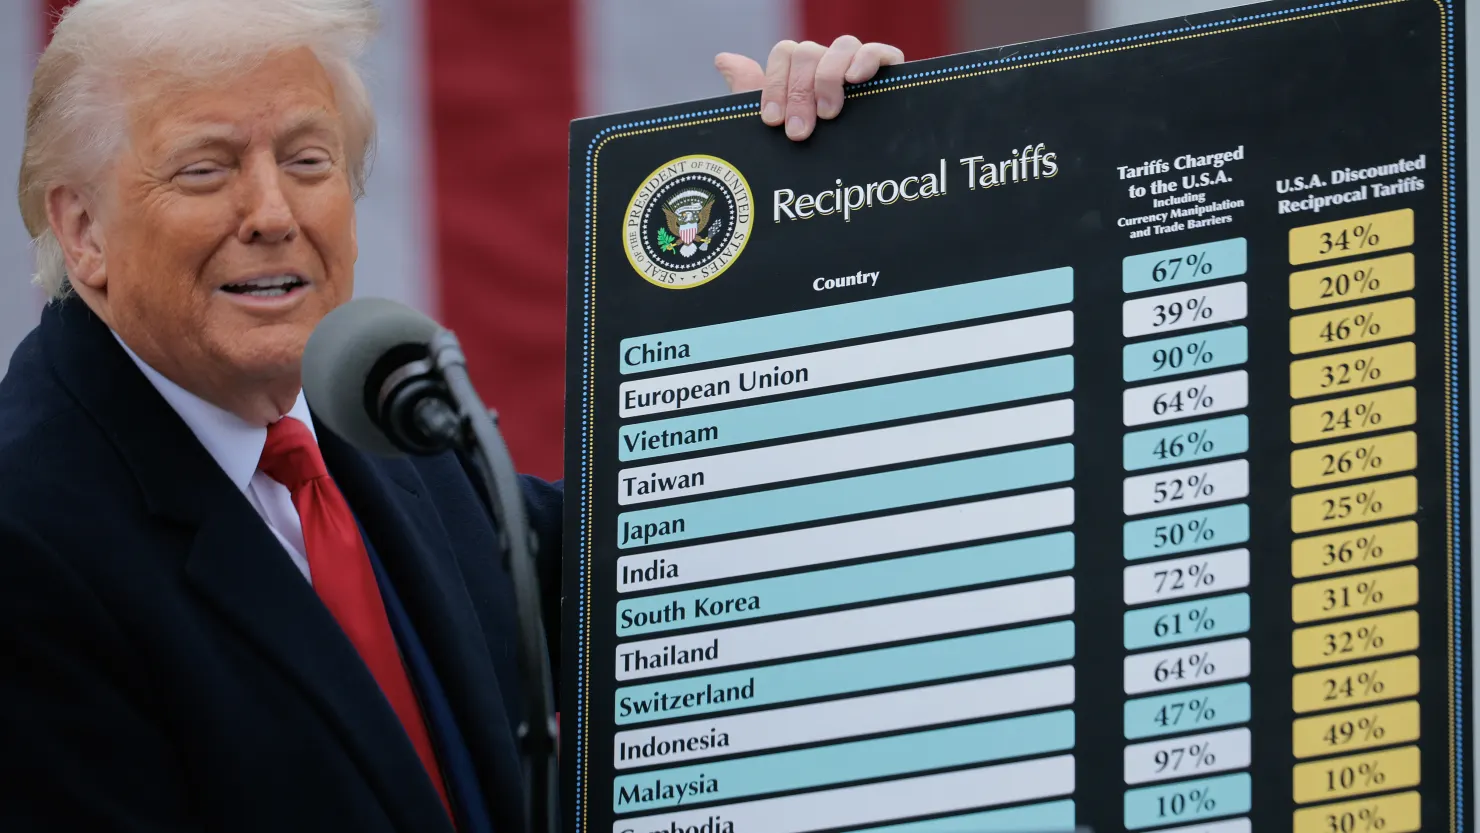

## Data Preparation

Given the length of the column titles and the augmented data, a bit of additional data preparation and cleanup is performed in the cell below. This preparation includes the following steps:
* Shortening several column names to simplify the axes and legends in the visualizations
* Mapping, in the data sense, the region information to a smaller categorical list
* Creating a new Population Category based on groups used by the UN

In [9]:
# Load dataset
df = pd.read_csv('Trump tariff gap consolidated.csv')

# We're using select_dtypes to automatically categorize our columns
# numeric_cols = list(df.select_dtypes(include=[np.number]).columns)
# categorical_cols = list(df.select_dtypes(exclude=[np.number]).columns)

# Clean the data - convert string numbers to float for GDP
df['GDP (USD billions)'] = pd.to_numeric(df['GDP (USD billions)'], errors='coerce')

# Create clean column name mapping to avoid special character issues
column_mapping = {
    'Trump Admin "White House Calculation" (%)': 'Trump_Admin_Calc',
    'WTO Trade-Weighted Average (%)': 'WTO_Average', 
    'Difference (Percentage Points)': 'Tariff Spread',
    'Trump Admin "USA Discounted Reciprocal Tariffs" (%)': 'Trump_Reciprocal',
    'Population (millions)': 'Population',
    'GDP (USD billions)': 'GDP',
    'Pop. Rank': 'Pop_Rank',
    'Country/Region': 'Country',
    'Trade Agreement': 'Trade_Agreement',
    'Key Market Group': 'Market_Group'
}

# Create a working copy with clean names
df_clean = df.rename(columns=column_mapping)

# Also keep original names for display
display_names = {v: k for k, v in column_mapping.items()}

# Get numeric and categorical columns (using clean names)
numeric_cols = ['Trump_Admin_Calc', 'WTO_Average', 'Tariff Spread', 'Trump_Reciprical', 'Population', 'GDP', 'Pop_Rank']
categorical_cols = ['Country', 'Trade_Agreement', 'Region', 'Market_Group', 'Population Category']

# Simplified region mapping
region_mapping = {
    'South America': 'S. America',
    'Oceania': 'Oceania',
    'Europe': 'Europe',
    'South Asia': 'Asia',
    'North America': 'N. America',
    'East Asia': 'Asia',
    'Central America & Caribbean': 'N. America',  # or 'South America' depending on your preference
    'Middle East & North Africa': 'Africa',
    'Sub-Saharan Africa': 'Africa',
    'Southeast Asia': 'Asia',
    'Central Asia': 'Asia'
}

df_clean['Region'] = df_clean['Primary Region'].map(region_mapping)


# Population category mapping
    # Micro: Under 1 million
    # Small: 1-10 million
    # Medium: 10-50 million
    # Large: 50-100 million
    # Very Large: Over 100 million
bins = [0, 1, 10, 50, 100, float('inf')]
labels = ['Micro', 'Small', 'Medium', 'Large', 'Very Large']
df_clean['Population Category'] = pd.cut(df_clean['Population'], 
                                 bins=bins, 
                                 labels=labels, 
                                 right=False)    
                 
data_summary = {
    col: {
        'type': str(df_clean[col].dtype),
        'missing': df_clean[col].isna().sum(),
        'unique_values': len(df_clean[col].unique())
    } for col in df_clean.columns
}

categorical_options = [col for col in df_clean.columns if df_clean[col].dtype == 'object' and df_clean[col].nunique() < 50]

select_var = pn.widgets.Select(
    name='Variable',
    options=['Tariff Spread', 'Trump_Admin_Calc', 'WTO_Average'],
    value='Trump_Admin_Calc'
)

select_group = pn.widgets.Select(
    name='Group By',
    # options=['Region', 'Trade_Agreement', 'Market_Group', 'Population Category'],
    options=categorical_options,
    value='Region'
)

pop_range = pn.widgets.RangeSlider(
    name='Population Filter (millions)',
    start=float(df_clean['Population'].min()),
    end=float(df_clean['Population'].max()),
    value=(float(df_clean['Population'].min()), float(df_clean['Population'].max())),
    step=1.0,
    format='0[.]0'
)

size_var = pn.widgets.Select(
    name='Size Variable',
    options=['Trump_Admin_Calc', 'WTO_Average', 'Tariff Spread', 'Population', 'GDP'],
    value='Population'
)


# Display our widgets in a nice layout
# ADVANCED FEATURE: Using * operator to unpack a list into arguments
controls = pn.Column(
    '## Dashboard Controls',
    *[widget for widget in [select_var, select_group, pop_range]],
    sizing_mode='stretch_width'
)

## Visualization Techniques
The following cells establish each of the key visualizations:

* Correlation heatmap - Similar to the source example this visual examines relationship betwee variables
* Histogram - Looks at the distribution of countries by regtion for various tariff rate sources
* Boxplot
* Scatter plot

The cells below create each widget in our dashboard.

In [10]:
def create_correlation_heatmap():
    """Creates a correlation heatmap."""
    # Only use numeric columns that exist and have data
    available_numeric = [col for col in numeric_cols if col in df_clean.columns and df_clean[col].notna().sum() > 0]
    
    if len(available_numeric) < 2:
        return pn.pane.Markdown("Not enough numeric data for correlation analysis")
    
    corr_data = df_clean[available_numeric].corr()
    
    plot = corr_data.hvplot.heatmap(
        title='Variable Correlations',
        height=400,
        width=400,
        cmap='RdBu_r',
        colorbar=True
    ).opts(xrotation=45)
    
    return plot

In [11]:
@pn.depends(select_var, select_group, pop_range)
def histogram_plot(select_var, select_group, pop_range):
    """Creates an interactive histogram."""
    filtered_df = df_clean[
        (df_clean['Population'] >= pop_range[0]) &
        (df_clean['Population'] <= pop_range[1])
    ]
    
    if filtered_df.empty:
        return pn.pane.Markdown("No data available for selected filters")
    
    # Get display name for title
    display_name = display_names.get(select_var, select_var)
    
    plot = filtered_df.hvplot.hist(
        y=select_var,
        by=select_group,
        bins=15,
        height=300,
        width=400,
        alpha=0.6,
        title=f'Distribution of {display_name}',
        xlabel=display_name,
        ylabel='Count'
    )
    return plot

In [12]:
@pn.depends(select_var, select_group, pop_range)
def box_plot(select_var, select_group, pop_range):
    """Creates an interactive box plot."""
    filtered_df = df_clean[
        (df_clean['Population'] >= pop_range[0]) &
        (df_clean['Population'] <= pop_range[1])
    ]
    
    if filtered_df.empty:
        return pn.pane.Markdown("No data available for selected filters")
    
    # Get display names
    var_display = display_names.get(select_var, select_var)
    group_display = display_names.get(select_group, select_group)
    
    plot = filtered_df.hvplot.box(
        y=select_var,
        by=select_group,
        height=300,
        width=400,
        title=f'Distribution of {var_display} by {group_display}'
    )
    return plot

In [13]:
@pn.depends(select_var, pop_range, size_var, select_group)
def create_scatter(x_var, pop_values, size_var, group_var):
    """Creates a scatter plot."""
    filtered_df = df_clean[
        (df_clean['Population'] >= pop_values[0]) & 
        (df_clean['Population'] <= pop_values[1])
    ].copy()
    
    if filtered_df.empty:
        return pn.pane.Markdown("No data available for selected filters")
    
    # Use a different y variable
    y_var = 'WTO_Average' if x_var != 'WTO_Average' else 'Population'
    
    # Get display names
    x_display = display_names.get(x_var, x_var)
    y_display = display_names.get(y_var, y_var)
    size_display = display_names.get(size_var, size_var)
    
    plot = filtered_df.hvplot.scatter(
        hover_cols = ['Country'],
        x=x_var,
        y=y_var,
        size=size_var,
        by=group_var,
        height=400,
        width=600,
        alpha=0.7,
        title=f'{x_display} vs {y_display} (sized by {size_display})',
        legend='right'
    )
    return plot

In [14]:
class ResponsiveTabbedDashboard:
    def __init__(self, widgets, plots):          
        self.widgets = widgets
        self.plots = plots
        self._layout = self.create_layout()
    
    def create_layout(self):
        sidebar = pn.Column(
            "## Dashboard Controls",
            *self.widgets,
            sizing_mode="stretch_width"
        )
        
        tabs = pn.Tabs(
            ('Overview', pn.Column(
                pn.Row(self.plots['boxplot'], self.plots['histogram'], sizing_mode='stretch_both'),
                sizing_mode='stretch_both'
            )),
            ('Relationships', pn.Row(
                self.plots['scatter'],
                self.plots['correlation'],
#                 self.plots['pop_correlation'],
                sizing_mode='stretch_both'
            )),
            ('Statistics', pn.Column(
                self.plots['stats'],
                sizing_mode='stretch_both'
            )),
#             ('Bonus', pn.Column(
#                 self.plots['pop_correlation'],
# #                 sizing_mode='stretch_both'
#             )),
            sizing_mode='stretch_both'
        )
        
        main_layout = pn.Column(
            tabs, 
            sizing_mode='stretch_both',
            min_height=600  # Minimum height for main layout
        )
        
        template = pn.template.VanillaTemplate(
            title="Trump Tariff Trauma Analysis Dashboard",
            sidebar=[sidebar],
            main=[main_layout]
        )
        
        return template
    
    def view(self):
        return self._layout
    
# Create and display dashboard
# print("Creating dashboard...")

dashboard = ResponsiveTabbedDashboard(
    widgets=[select_var, select_group, pop_range, size_var],
    plots={
        'histogram': histogram_plot,
        'boxplot': box_plot,
        'scatter': create_scatter,
        'correlation': create_correlation_heatmap,
#         'pop_correlation': pop_spread_heatmap,
        'stats': pn.pane.DataFrame(pd.DataFrame(data_summary).T)
    }
)

dashboard.view()

VanillaTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=True, device_pixel_ratio=2, language='en-US', timezone='America/Los_Angeles', timezone_offset=420, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-13824861328] Column(min_height=600, sizing_mode='stretch_both')
        [0] Tabs(sizing_mode='stretch_both')
            [0] Column(sizing_mode='stretch_both')
                [0] Row(sizing_mode='stretch_both')
                    [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
                    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
            [1] Row(sizing_mode='stretch_both')
                [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
                [1] Column(sizing_mode='fixed')
                    [0] Column()
                    [1] Row(sizing_mode='fixed')
                        [0] HoloViews(HeatMap, height=400, name='interactive02485', sizing_mode='fixed', width=400)
            [2] Column(sizing_mode='stretch_both')
                [0] DataFrame(DataFrame)
    [nav-13809847568] Column(sizing_mode='stretch_width')
        [0] Markdown(str)
        [1] Select(name='Variable', options=['Tariff Spread', ...], value='Trump_Admin_Calc')
        [2] Select(name='Group By', options=['Trade_Agreement', ...], value='Region')
        [3] RangeSlider(end=1425.7, format='0[.]0', name='Population Filter (..., start=0.4, step=1.0, value=(0.4, 1425.7), value_end=1425.7, value_start=0.4)
        [4] Select(name='Size Variable', options=['Trump_Admin_Calc', ...], value='Population')

## Deployment

To experience the interactivity without issue, I recommend that you deploy this notebook locally. My attempts to maintain the interactivity of the dashboard in notebooks deployed on Data Lab and Google Colab were unsuccessful. 

The source code and dataset are available at [GitHub](https://github.com/hnewton/521-interactive).

## Key Learnings

### Process & Data

Although it is impressive and somewhat fun to have the ability to explore a dataset rather than only looking at charts, I question whether this combination of libraries is the right solution. Perhaps it will get easier with more practice and knowledge, although the deployment challenges will likely remain. Until then my assessment is that it would be difficult to justify the addiitonal time and brittle nature of what is created, especially for a one-off exploration. 

If the use case included the need to frequently retrieve similar datasets via an API or regular use of updated or refreshed datasets, then the repeatability would increase the value of this interactive experience. 

A few key highlights of lessons:
* The filtering slide for Population was the most useful of the components
* Keep the column names, descriptive and brief
* Put in the time to prepare and normalize the dataset
* Everything is configurable, even if not very obvious how to make the adjustment
* Despite the declarative nature of the chosen libraries, the procedural qualities of the hybrid approach make it feel more like a custom toolset. However, what you get you get in custom fit and flexibility, you give up in speed and stability. 
* The user experience with responsiveness added to the dashboard is underwhelming. As you scroll down the notebook, you will often and unintentionally zoom in/out of a particular graph. These user experience frustrations alone undermine much of the value from the interactivity
* The overall experience of this combination as a user and developer feels like a good looking sweater that doesn't fit quite right, requires delicate care, continually scratches your skin and remains unused after wearing it a few times. 